In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D

In [2]:
is_ripple, spikes, position, speed, env, time, position2D = load_data()
spikes = (spikes > 0).astype(int)
spike_times = [time[spike.astype(bool)] for spike in spikes.T]


sampling_frequency = 500
time_range = (time[0], time[-1] + (1 / sampling_frequency))

n_time_bins = int((time_range[-1] - time_range[0]) * sampling_frequency) + 1
t = time_range[0] + np.arange(n_time_bins) / sampling_frequency

np.allclose(t, time)

25-Jun-25 11:44:20 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True

In [3]:
env

Environment(environment_name='', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x113216ab0>, edge_order=[(0, 1), (1, 2), (2, 3), (1, 4), (4, 5)], edge_spacing=[15, 0, 15, 0], is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0)

In [14]:
from non_local_detector import Environment

new_env = Environment.from_graph(
    graph=env.track_graph,
    edge_order=env.edge_order,
    edge_spacing=env.edge_spacing,
    bin_size=env.place_bin_size,
)

In [15]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    environments=[new_env],
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

25-Jun-25 11:59:46 Fitting initial conditions...
25-Jun-25 11:59:46 Fitting discrete state transition
25-Jun-25 11:59:46 Fitting continuous state transition...
25-Jun-25 11:59:46 Fitting place fields...


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

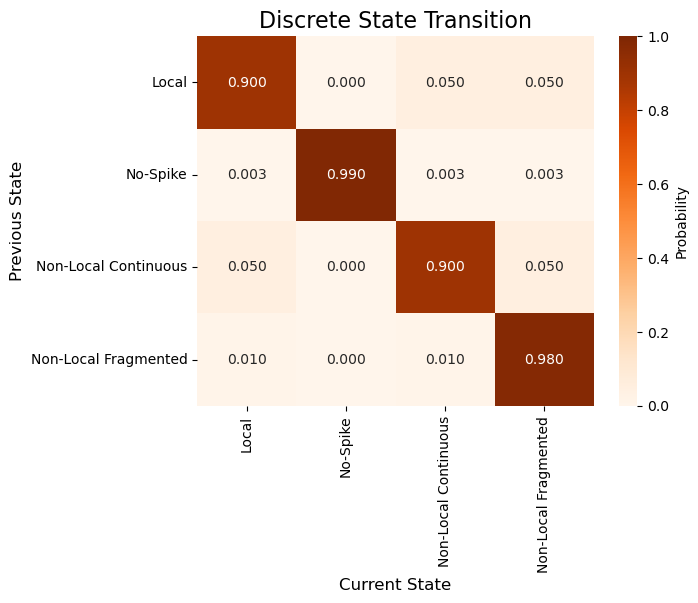

In [16]:
detector.plot_discrete_state_transition()

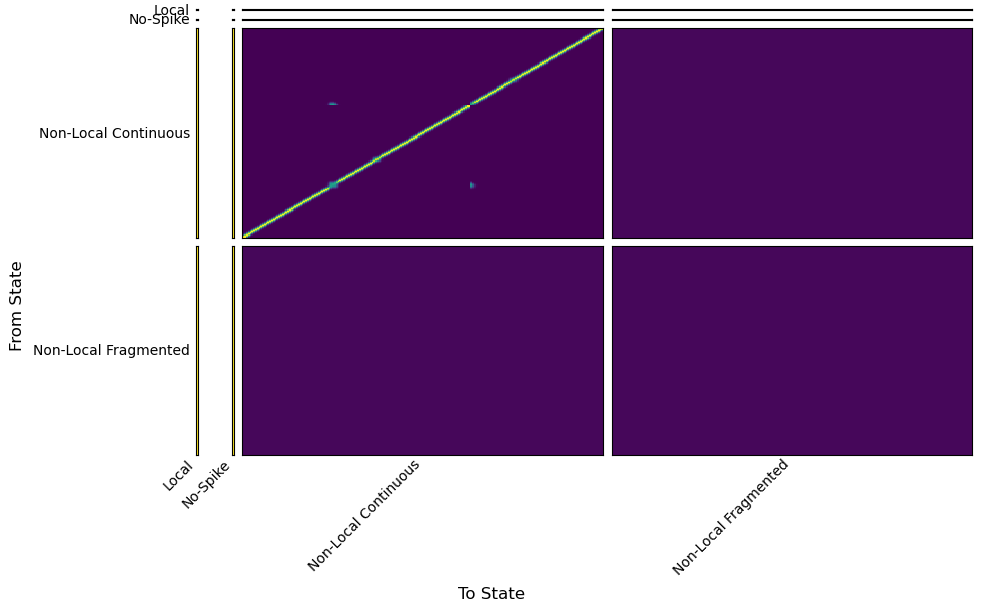

In [59]:
detector.plot_continuous_state_transition()

/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


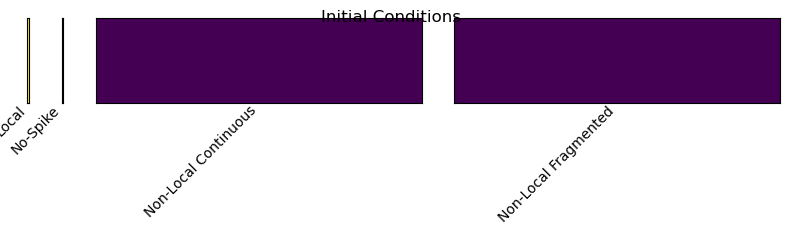

In [60]:
detector.plot_initial_conditions()

In [17]:
results = detector.predict(spike_times, time, position2D, time)
results

25-Jun-25 11:59:51 Computing posterior...
25-Jun-25 11:59:51 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1191: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(


<xarray.Dataset> Size: 742MB
Dimensions:                      (time: 452325, state_bins: 404, states: 4,
                                  state_ind: 404)
Coordinates:
  * time                         (time) float64 4MB 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object 3kB MultiIndex
  * state                        (state_bins) object 3kB 'Local' ... 'Non-Loc...
  * x_position                   (state_bins) float64 3kB nan nan ... 106.4
  * y_position                   (state_bins) float64 3kB nan nan ... 100.4
  * state_ind                    (state_ind) int64 3kB 0 1 2 2 2 2 ... 3 3 3 3 3
  * states                       (states) <U20 320B 'Local' ... 'Non-Local Fr...
    environments                 (states) <U1 16B '' '' '' ''
    encoding_groups              (states) int64 32B 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 731MB 1.0 ... 0.0...
    acausal_state_probabilities  (time, states) float32 7MB 1.0 ... 0.7145
Attributes:
    marginal_log_likelihoods:  -1931857.5

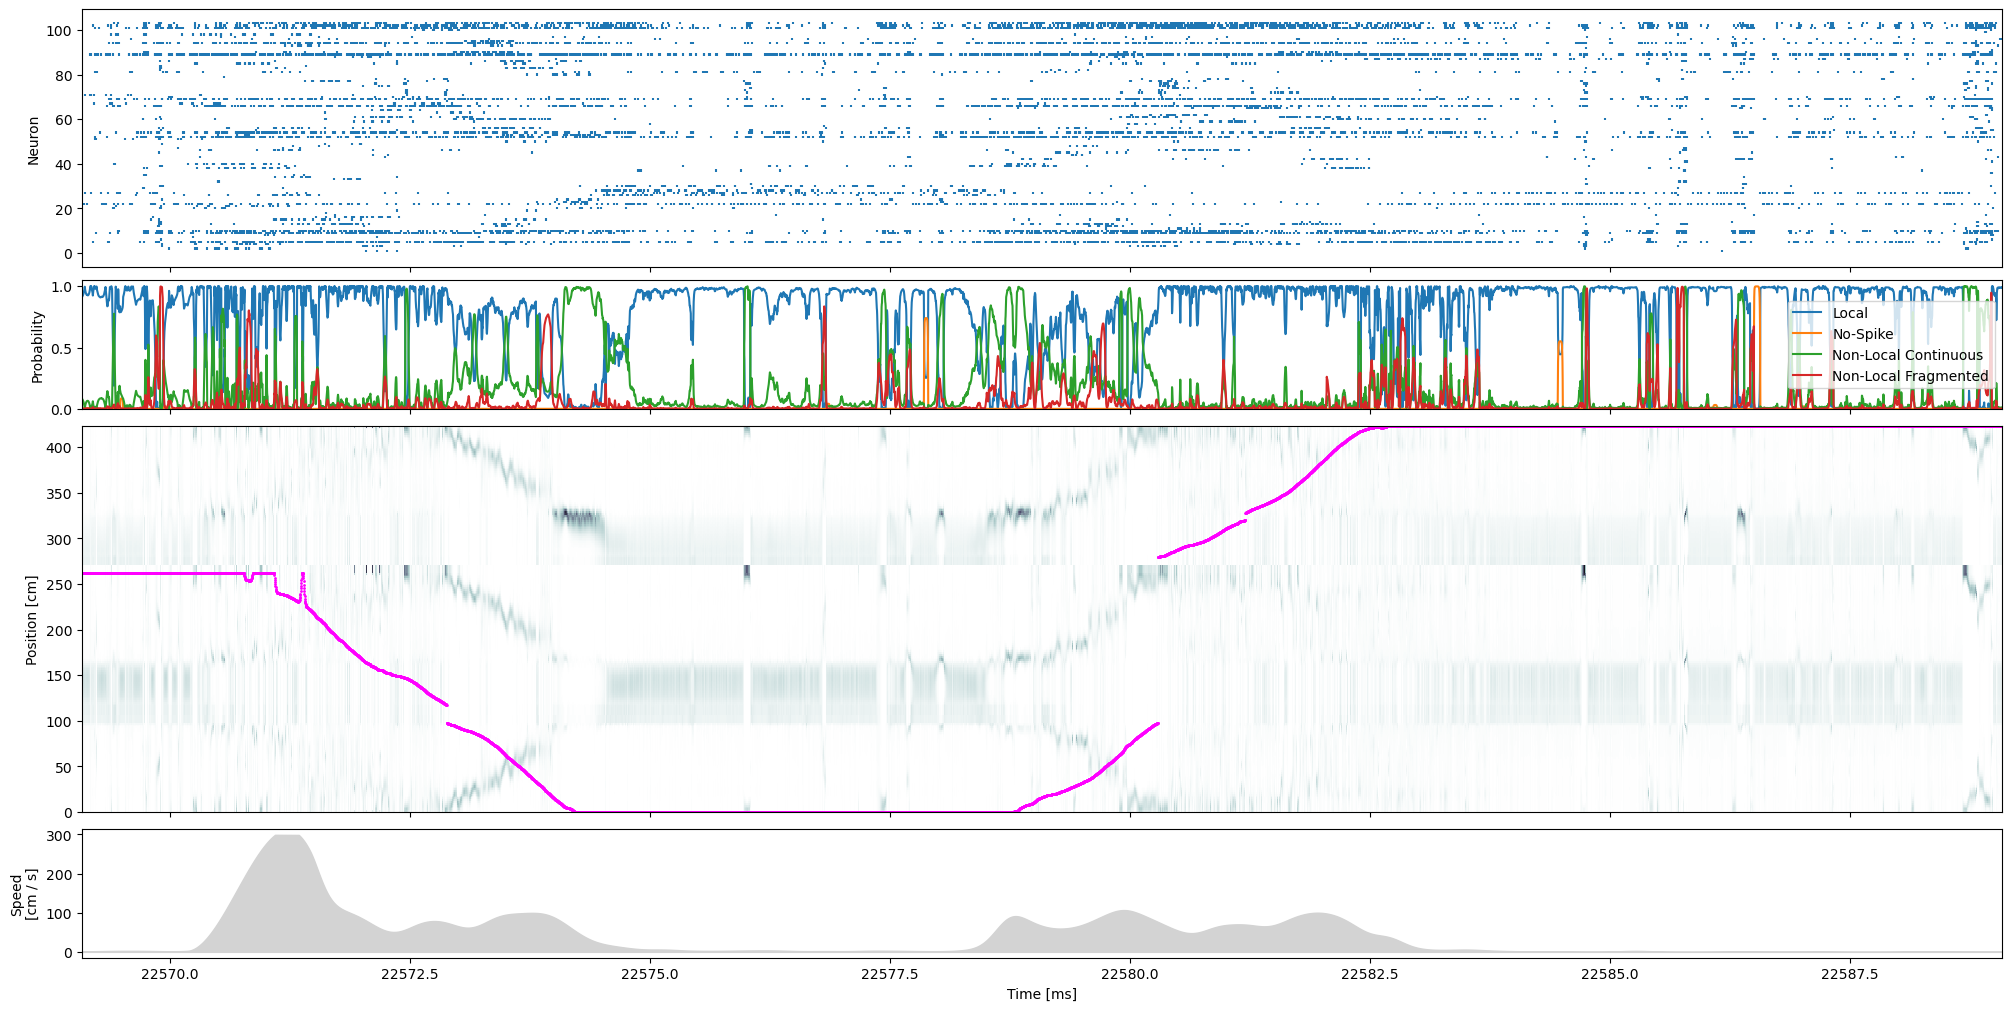

In [ ]:
# from non_local_detector.visualization import plot_non_local_model
import matplotlib.pyplot as plt
import matplotlib
import copy
from typing import Union, Optional, Tuple
import xarray as xr
from non_local_detector import NonLocalClusterlessDetector, NonLocalSortedSpikesDetector
import numpy as np


def plot_non_local_model(
    position_time: np.ndarray,
    position: np.ndarray,
    spike_times: list[np.ndarray],
    speed: np.ndarray,
    detector: Union[NonLocalClusterlessDetector, NonLocalSortedSpikesDetector],
    results: xr.Dataset,
    figsize: Tuple[int, int] = (20, 10),
    time_slice: Optional[slice] = None,
    posterior_max: float = 0.25,
) -> None:
    """Plot the results of a non-local model.

    Parameters
    ----------
    position_time : np.ndarray
    position : np.ndarray
    spike_times : list[np.ndarray]
    speed : np.ndarray
    detector : Union[NonLocalClusterlessDetector, NonLocalSortedSpikesDetector]
    results : xr.Dataset
    figsize : Tuple[int, int], optional
    time_slice : Optional[slice], optional
    posterior_max : float, optional
    """
    if time_slice is None:
        time_slice = slice(results.time.values[0], results.time.values[-1])

    env = detector.environments[0]
    linear_bin_centers = env.to_linear(env.bin_centers)
    linear_position = env.to_linear(position)
    try:
        place_fields = detector.encoding_model_[("", 0)]["place_fields"]
        neuron_sort_ind = np.argsort(
            linear_bin_centers[np.nanargmax(place_fields, axis=1)].squeeze()
        )
        cell_label = "Neuron"
    except KeyError:
        neuron_sort_ind = np.arange(len(spike_times))
        cell_label = "Electrode\nGroup"

    state_names = detector.state_names
    acausal_state_probabilities = results.sel(
        time=time_slice
    ).acausal_state_probabilities.values
    acausal_posterior = results.sel(time=time_slice).acausal_posterior
    results_time = results.sel(time=time_slice).time.values

    _, axes = plt.subplots(
        4,
        1,
        sharex=True,
        constrained_layout=True,
        figsize=figsize,
        gridspec_kw={"height_ratios": [2, 1, 3, 1]},
    )

    t, x = np.meshgrid(results_time, linear_bin_centers)

    conditional_non_local_acausal_posterior = (
        acausal_posterior.sel(
            state_bins=(acausal_posterior.state == "Non-Local Continuous")
        ).values
        + acausal_posterior.sel(
            state_bins=(acausal_posterior.state == "Non-Local Fragmented")
        ).values
    )
    conditional_non_local_acausal_posterior /= np.nansum(
        conditional_non_local_acausal_posterior, axis=1
    )[:, np.newaxis]

    new_spike_times = [
        spike_times[neuron_id][
            np.logical_and(
                spike_times[neuron_id] >= time_slice.start,
                spike_times[neuron_id] <= time_slice.stop,
            )
        ]
        for neuron_id in neuron_sort_ind
    ]
    axes[0].eventplot(new_spike_times)
    axes[0].set_ylabel(cell_label)

    h = axes[1].plot(results_time, acausal_state_probabilities)
    axes[1].legend(h, state_names)
    axes[1].set_ylabel("Probability")
    axes[1].set_ylim((0.0, 1.05))

    cmap = copy.copy(matplotlib.colormaps["bone_r"])
    cmap.set_bad(color="lightgrey")

    axes[2].pcolormesh(
        t,
        x,
        conditional_non_local_acausal_posterior.T,
        vmin=0.0,
        vmax=posterior_max,
        cmap=cmap,
    )
    is_valid_position_time = np.logical_and(
        position_time >= time_slice.start, position_time <= time_slice.stop
    )
    axes[2].scatter(
        position_time[is_valid_position_time],
        linear_position[is_valid_position_time],
        s=1,
        color="magenta",
        zorder=2,
    )
    axes[2].set_ylabel("Position [cm]")
    axes[3].fill_between(
        position_time[is_valid_position_time],
        speed[is_valid_position_time],
        color="lightgrey",
        zorder=2,
    )
    axes[3].set_ylabel("Speed\n[cm / s]")
    plt.xlim((time_slice.start, time_slice.stop))
    plt.xlabel("Time [ms]")


plot_non_local_model(
    time,
    position2D,
    spike_times,
    speed,
    detector,
    results,
    time_slice=slice(time[90_000], time[100_000]),
    figsize=(20, 10),
)

In [19]:
# from non_local_detector import NonLocalSortedSpikesDetector


# detector = NonLocalSortedSpikesDetector(
#     environments=new_env,
#     sorted_spikes_algorithm="sorted_spikes_kde",
#     sorted_spikes_algorithm_params={
#         "position_std": np.sqrt(12.5),
#         "block_size": int(2**12),
#     },
# )
# detector.estimate_parameters(
#     time=time[:100],
#     position_time=time[:100],
#     position=position2D[:100],
#     spike_times=spike_times,
#     is_training=~is_ripple[:100],
# )

In [123]:
from non_local_detector import SortedSpikesDecoder

decoder = SortedSpikesDecoder(
    environments=new_env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)
results2 = decoder.predict(
    spike_times=spike_times,
    time=time
)

25-Jun-25 15:34:47 Fitting initial conditions...


25-Jun-25 15:34:47 Fitting discrete state transition
25-Jun-25 15:34:47 Fitting continuous state transition...
25-Jun-25 15:34:47 Fitting place fields...


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

25-Jun-25 16:02:06 Computing posterior...
25-Jun-25 16:02:22 Computing log likelihood...


Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1191: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(


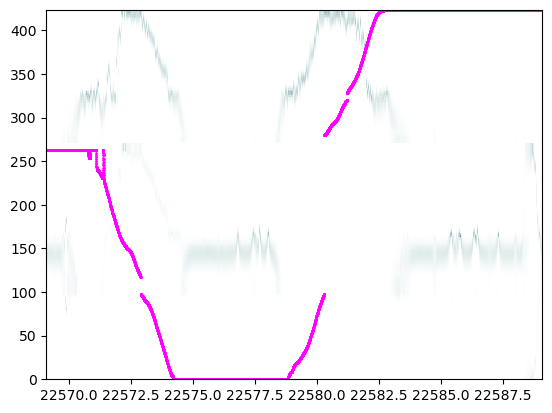

In [ ]:
t, x = np.meshgrid(results2.sel(time=time_slice).time.values, new_env.to_linear(new_env.bin_centers))
plt.pcolormesh(
    t,
    x,
    results2.acausal_posterior.sel(time=time_slice).values.T,
    vmin=0.0,
    cmap="bone_r",
)
time_slice_ind = slice(
    np.searchsorted(results2.time.values, time_slice.start),
    np.searchsorted(results2.time.values, time_slice.stop),
)
plt.scatter(
    time[time_slice_ind],
    new_env.to_linear(position2D[time_slice_ind]),
    s=1,
    color="magenta",
    zorder=2,

)

In [75]:
results2

<xarray.Dataset> Size: 369MB
Dimensions:                      (time: 452325, state_bins: 201, state_ind: 201)
Coordinates:
  * time                         (time) float64 4MB 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object 2kB MultiIndex
  * state                        (state_bins) object 2kB 'Continuous' ... 'Co...
  * x_position                   (state_bins) float64 2kB 105.0 103.0 ... 106.4
  * y_position                   (state_bins) float64 2kB 53.64 53.66 ... 100.4
  * state_ind                    (state_ind) int64 2kB 0 0 0 0 0 0 ... 0 0 0 0 0
    states                       <U10 40B 'Continuous'
    environments                 <U1 4B ''
    encoding_groups              int64 8B 0
Data variables:
    acausal_posterior            (time, state_bins) float32 364MB 7.833e-12 ....
    acausal_state_probabilities  (time) float32 2MB 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes:
    marginal_log_likelihoods:  -2074997.9

Text(0.5, 1.0, 'Neuron 4')

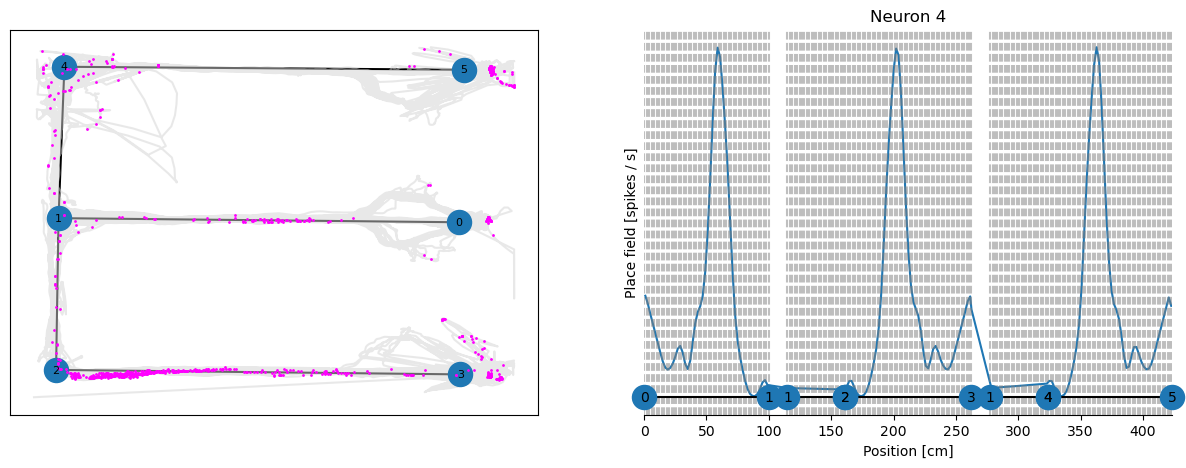

In [122]:
from track_linearization import plot_track_graph

place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
neuron_ind = 4

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(position2D[:, 0], position2D[:, 1], color="lightgrey", alpha=0.5)
plot_track_graph(
    new_env.linearization_properties["track_graph"],
    ax=axes[0],
)
# plot node id
for node_id, node_data in new_env.linearization_properties["track_graph"].nodes(data=True):
    axes[0].text(
        node_data["pos"][0],
        node_data["pos"][1],
        str(node_id),
        fontsize=8,
        ha="center",
        va="center",
        color="black",
    )

position_at_spike_time = position2D[np.searchsorted(time, spike_times[neuron_ind])]
axes[0].scatter(
    position_at_spike_time[:, 0],
    position_at_spike_time[:, 1],
    s=1,
    color="magenta",
    zorder=2,
)


axes[1].plot(new_env.to_linear(new_env.bin_centers), place_fields[neuron_ind])
new_env.plot_1D(ax=axes[1])
axes[1].set_xlabel("Position [cm]")
axes[1].set_ylabel("Place field [spikes / s]")
axes[1].set_title(f"Neuron {neuron_ind}")

Text(0.5, 0, 'Position [cm]')

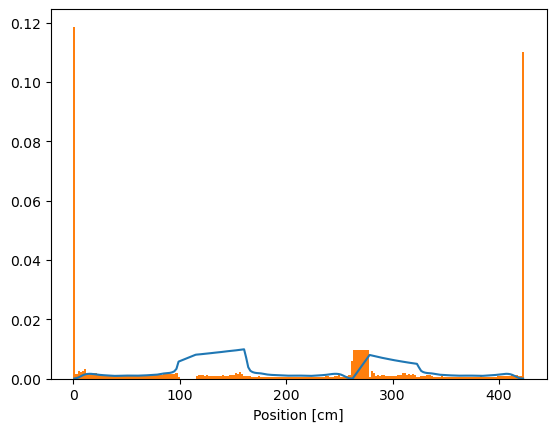

In [164]:
plt.plot(new_env.to_linear(new_env.bin_centers), decoder.encoding_model_[("", 0)]["occupancy"])
plt.hist(
    new_env.to_linear(position2D),
    bins=new_env.grid_edges[0],
    density=True,
)
plt.xlabel("Position [cm]")

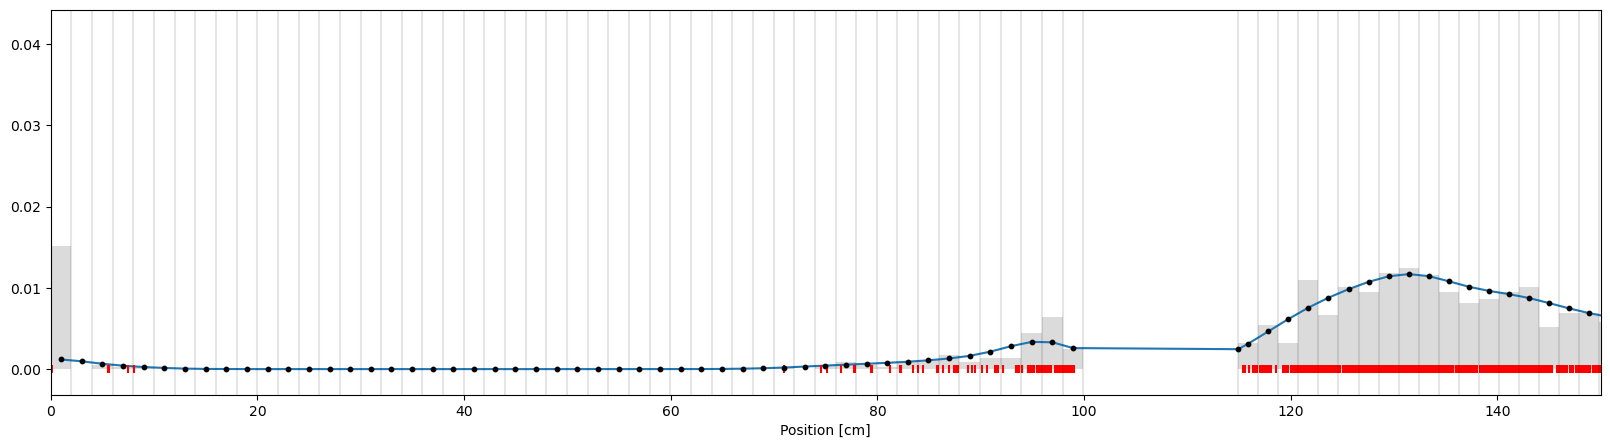

In [206]:
neuron_ind = 5
position_at_spike_time = position2D[np.searchsorted(time, spike_times[neuron_ind])]

marginal = decoder.encoding_model_[("", 0)]["marginal_models"][neuron_ind].predict(
    new_env.to_linear(new_env.bin_centers))

plt.figure(figsize=(20, 5))
plt.plot(new_env.to_linear(new_env.bin_centers), marginal, label="Marginal")
plt.scatter(new_env.to_linear(new_env.bin_centers), marginal, label="Marginal", s=10, color="black", zorder=10)
plt.eventplot(env.to_linear(position_at_spike_time), color="red", linelengths=0.001, lineoffsets=0.0)
plt.hist(
    env.to_linear(position_at_spike_time),
    bins=new_env.grid_edges[0],
    density=True,
    alpha=0.8,
    label="Position distribution",
    facecolor="lightgrey",
)
plt.xlabel("Position [cm]")
plt.xlim((0, 150))
for i in new_env.grid_edges[0]:
    plt.axvline(i, color="black", alpha=0.1)

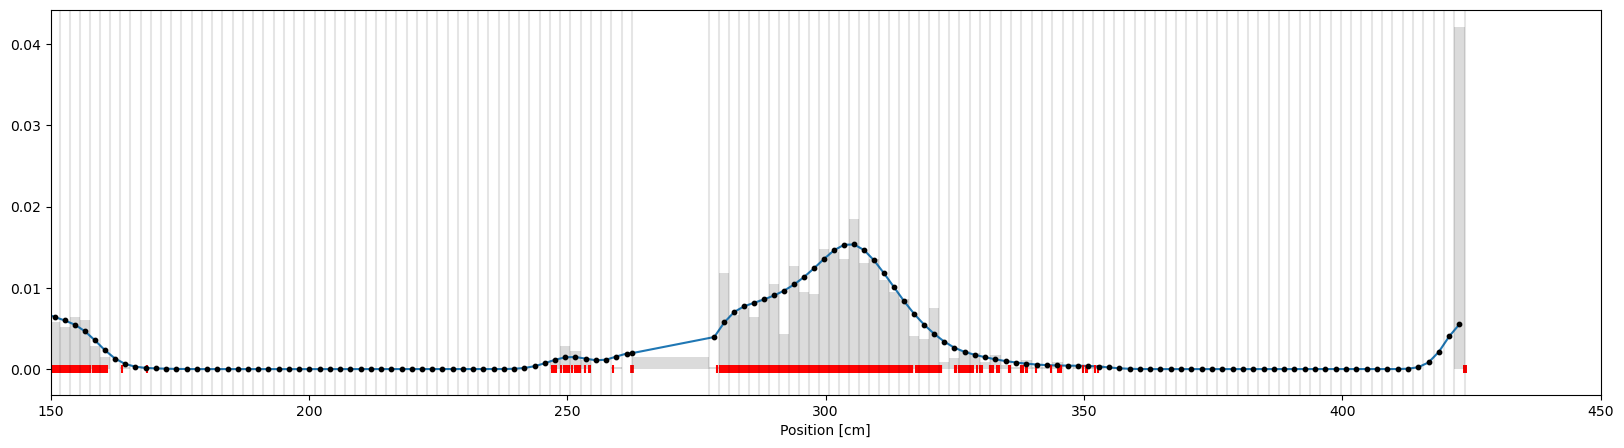

In [207]:
neuron_ind = 5
position_at_spike_time = position2D[np.searchsorted(time, spike_times[neuron_ind])]

marginal = decoder.encoding_model_[("", 0)]["marginal_models"][neuron_ind].predict(
    new_env.to_linear(new_env.bin_centers)
)

plt.figure(figsize=(20, 5))
plt.plot(new_env.to_linear(new_env.bin_centers), marginal, label="Marginal")
plt.scatter(
    new_env.to_linear(new_env.bin_centers),
    marginal,
    label="Marginal",
    s=10,
    color="black",
    zorder=10,
)
plt.eventplot(
    env.to_linear(position_at_spike_time),
    color="red",
    linelengths=0.001,
    lineoffsets=0.0,
)
plt.hist(
    env.to_linear(position_at_spike_time),
    bins=new_env.grid_edges[0],
    density=True,
    alpha=0.8,
    label="Position distribution",
    facecolor="lightgrey",
)
plt.xlabel("Position [cm]")
plt.xlim((150, 450))
for i in new_env.grid_edges[0]:
    plt.axvline(i, color="black", alpha=0.1)

In [187]:
new_env.bin_centers[~new_env.active_mask]

array([[  6.12328247,  54.88178207],
       [106.50942684,   6.9994206 ]])

In [188]:
(~new_env.active_mask).nonzero()[0]

array([ 50, 126])

In [196]:
np.diff(new_env.to_linear(new_env.bin_centers))

array([ 1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303,  1.99864303,
        1.99864303,  1.99864303,  1.99864303,  1.99864303, 15.99932152,
        0.96906471,  1.93812942,  1.93812942,  1.93812942,  1.93812942,
        1.93812942,  1.93812942,  1.93812942,  1.93812942,  1.93812942,
        1.93812942,  1.93812942,  1.93812942,  1.93812942,  1.93812942,
        1.93812942,  1.93812942,  1.93812942,  1.93812942,  1.93

In [154]:
new_env.bin_centers.shape

(201, 2)